# KnowledgeCore tutorial

This is a tutorial for KnowledgeCore, the knowledge base installed on PAL Robotics' robots.

The notebook assumes the knowledge base to be already running, either on a robot, or in the developers' Docker image.


In [1]:
import rospy
from knowledge_core.api import KB

rospy.init_node("kb_notebook")
kb = KB()

## Exercise 1: the False Belief experiment

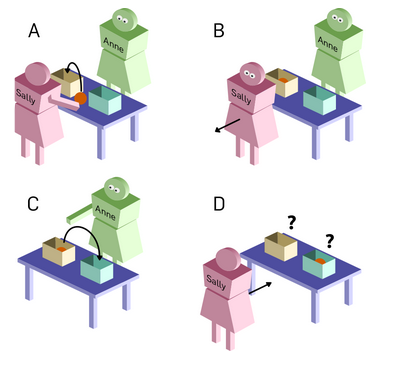

### Step 1: Add two human, Anne and Sally

In [2]:
kb += "anne rdf:type Human"
kb += "sally rdf:type Human"

# alternatively:
# kb += ["anne rdf:type Human", "sally rdf:type Human"]

Result:

<div>
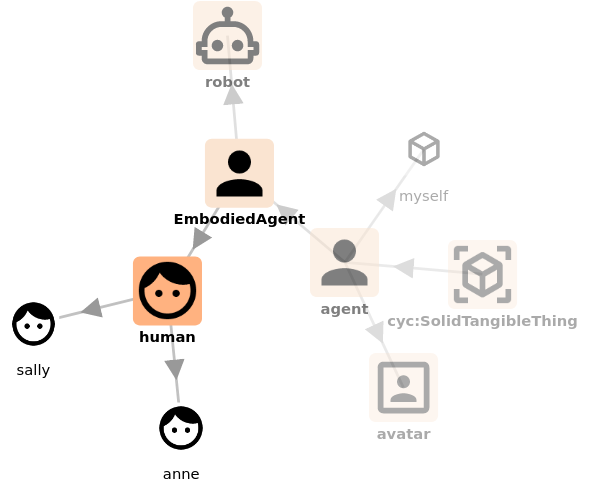
</div>


### Step 2: Add objects

Add a robot, ARI.
Add as well a table, and on top of it, two boxes (blue and beige), and a red ball.

Use the KnowledgeBase graphical explorer to find pre-defined classes for a table, boxes, and a ball:

<div>
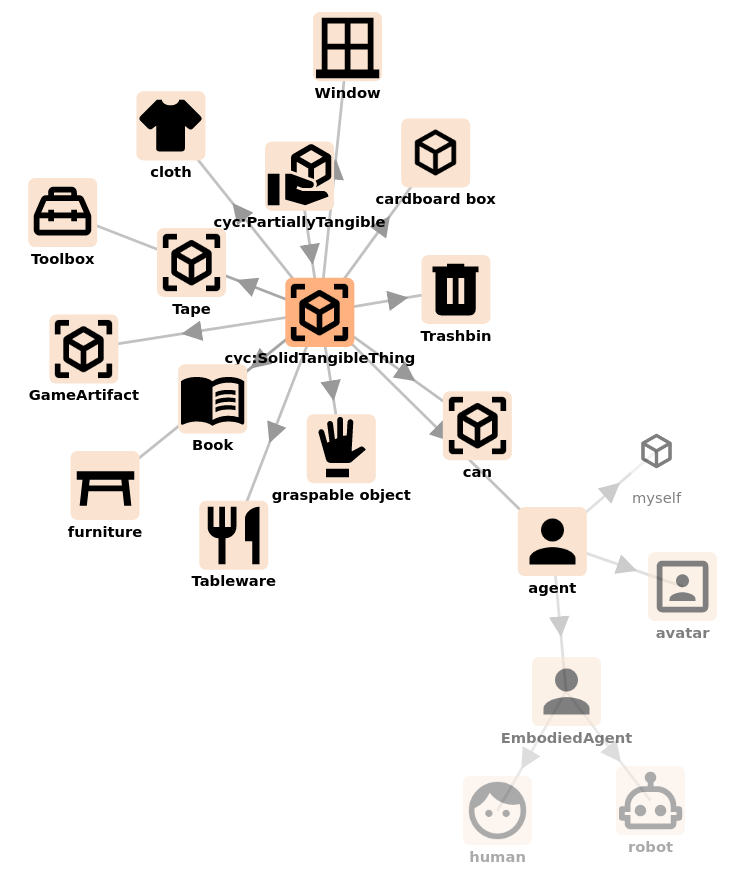
</div>


In [3]:
kb += ["ari rdf:type Robot", "table1 rdf:type cyc:Table-PieceOfFurniture", "bluebox rdf:type Box", "beigebox rdf:type Box", "ball rdf:type Ball"]

Two comments:

1. the class of `table1` is `cyc:Table-PieceOfFurniture`: this is one example where the OpenRobots Ontology is reusing a concept defined in the OpenCyC Upper ontology, instead of redefining it.

2. the class `Ball` is not actually defined in the OpenRobots Ontology. However, the simple fact that we reference it as the type of the instance `ball` means that it is now known to KnowledgeCore.

   `Ball` is however not yet related to any other class. For instance, if we query for all the known objects (class `Artifact`), our `ball` won't show up:

In [4]:
kb["* rdf:type Artifact"]

[{'var1': 'bluebox'}, {'var1': 'table1'}, {'var1': 'beigebox'}]

We can tell KnowledgeCore that balls are type of objects, and then, our ball will be listed, as expected:

In [5]:
kb += ["Ball rdfs:subClassOf Artifact"]
kb["* rdf:type Artifact"]

[{'var1': 'beigebox'},
 {'var1': 'ball'},
 {'var1': 'table1'},
 {'var1': 'bluebox'}]

On a real robot, statements like these would typically be added by a custom 'semantic scene understanding' module. This is not done automatically.


In [6]:
kb += ["beigebox isOn table1", "bluebox isOn table1", "ball isOn table1"]

### Step 3: State that the robot is looking at Sally, and that Sally is putting the red ball in the beige box

In [7]:
kb += ["ari looksAt sally"]

<div>
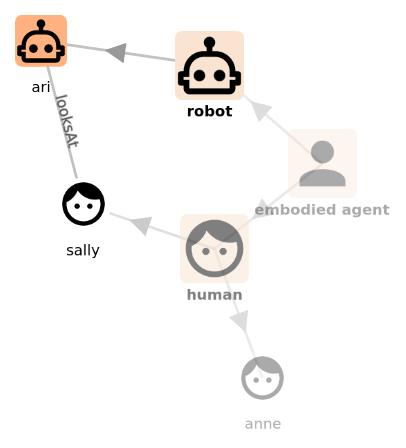
</div>

If you open the OpenRobot Ontology in Protégé, you can check how `looksAt` is defined:

<div>
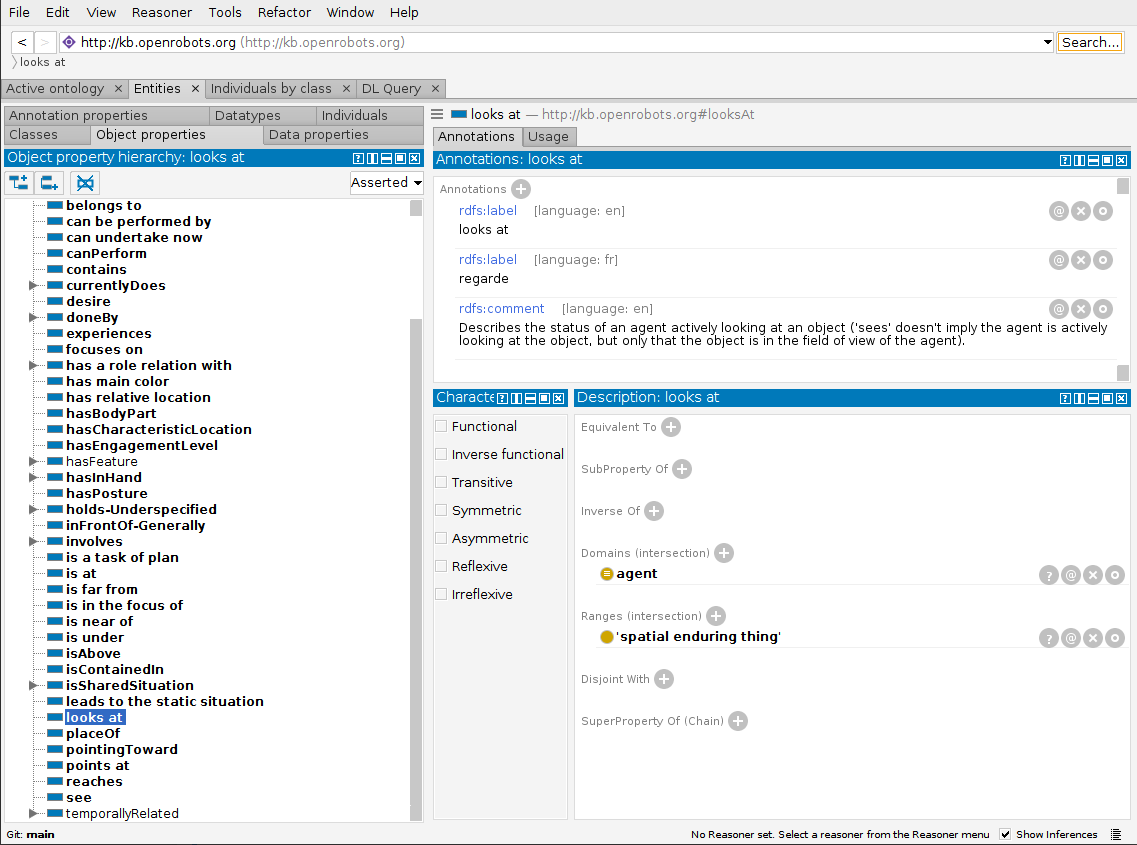
</div>

In [8]:
kb += ["action1 rdf:type Put", "action1 actsOnObject ball", "action1 receivedBy beigebox"]
kb += ["sally currentlyPerforms action1"]

Result:

<div>
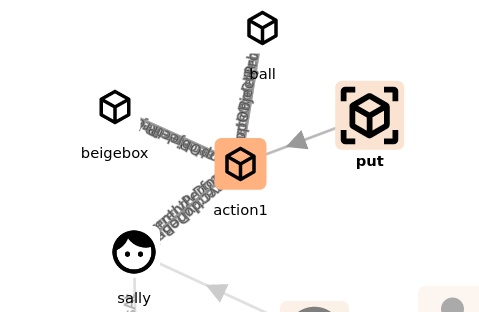
</div>

On a real robot, statements like these would typically be added by a custom 'human action monitoring' module. This is not done automatically.

Also, these statements are *static*: you need to update/remove them when eg the action ends.


### Step 4: location of the red ball

First, we place the ball in the beige box:

In [9]:
kb += "ball isIn beigebox"

If we now query the location of the ball, it appears in two locations:

In [10]:
kb["ball isAt *"]

[{'var1': 'beigebox'}, {'var1': 'table1'}]

- First, note that `isIn` and `isOn` are *sub-property* of `isAt`: thus if `ball isIn beigebox`, `ball isAt beigebox` is also true, and we query `isAt` to know of all possible location.

- Second, it might seem curious that the knowledge base allows for the same object to be in two different location. Consider however the following case: `ball isIn beigebox` and `ball isIn livingroom`. Both statements might well be true! in general, an individual might have several `isAt` statements.

For now, let's remove `ball isOn table1`:

In [11]:
kb -= "ball isOn table1"
kb["ball isAt *"]

[{'var1': 'beigebox'}]

### Step 5: belief models

We can create independent belief models for Sally and Anne:

In [12]:
# add statements to both models -- this implicitely *creates* a model for Sally and one for Anne
kb.add(["ball isIn beigebox"], models=["sally", "anne"])

In [13]:
# here, we only modify Anne's model: we create divergent belief models
kb.remove(["ball isIn beigebox"], models=["anne"])
kb.add(["ball isIn bluebox"], models=["anne"])

In [14]:
kb["ball isAt *", ["sally"]]

[{'var1': 'beigebox'}]

In [15]:
kb["ball isAt *", ["anne"]]

[{'var1': 'bluebox'}]

In [16]:
# the default model (ie, the robot model) is independent of the other two
kb["ball isAt *"]

[{'var1': 'beigebox'}]

### Step 6: create an event monitor

In [17]:
# first, we create a callback function
def on_anne_moves_ball(evt):
    print(f"Event triggered! Anne moved the ball: {evt}")
    
    # update the location of the ball in both Anne's and the robot's belief models
    kb.remove(["ball isIn ?_"], ["default", "anne"])
    kb.add([f"ball isIn {evt[0]['box']}"], ["default", "anne"])

In [18]:
kb.subscribe(["anne currentlyPerforms ?act", 
              "?act rdf:type Put", 
              "?act actsOnObject ball", 
              "?act receivedBy ?box", 
              "?box rdf:type Box"], on_anne_moves_ball)

'evt_b7803b359a5dba4d02721c07f1c2c8a7'

In [19]:
kb += ["action2 rdf:type Put", "action2 actsOnObject ball", "action2 receivedBy bluebox"]
kb += ["anne currentlyPerforms action2"]

Event triggered! Anne moved the ball: [{'act': 'action2', 'box': 'bluebox'}]


We can now query KnowledgeCore for the 3 belief models.

In [20]:
kb["ball isAt *", ["anne"]]

[{'var1': 'bluebox'}]

In [21]:
kb["ball isAt *", ["sally"]]

[{'var1': 'beigebox'}]

In [22]:
kb["ball isAt *", ["default"]]

[{'var1': 'bluebox'}]

## Exercise 2: control a robot in simulation

<div>
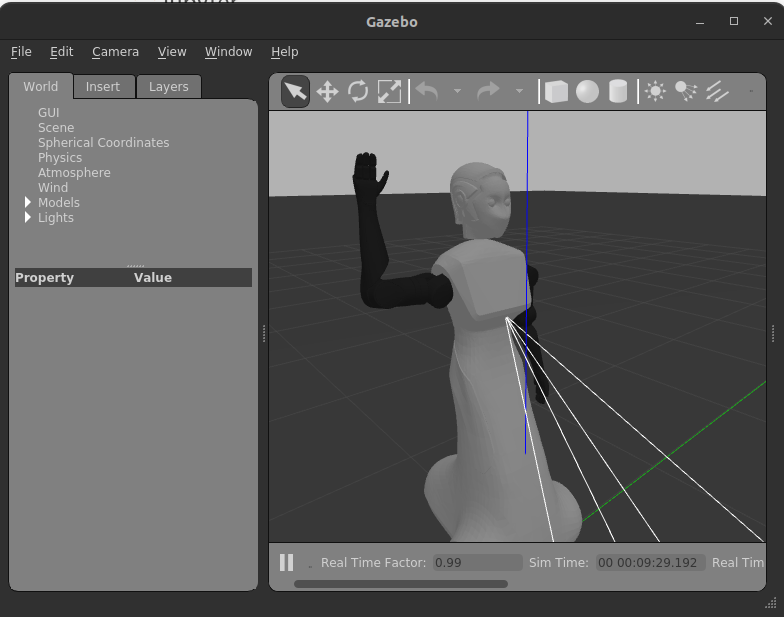
</div>

First, start the simulator. Refer to the [training slides](https://docs.google.com/presentation/d/1HGq8hJtgp94Bc9Qa5D9yUGiUL3H_lplNXNj_OfcPAbU#slide=id.g2c8bb31aa1d_0_33) to know how to do that.

Then, let's write a small piece of ROS code to execute a gesture on the robot:

In [25]:
import rospy
# Brings in the SimpleActionClient
import actionlib

# Brings in the 'play motion' messages, used to play pre-recoreded gestures
from play_motion_msgs.msg import PlayMotionAction, PlayMotionGoal 


When you execute the cell below, you should see the robot waving in the simulator window.

In [24]:
# create a simple 'client' for the play_motion server running in simulation
client = actionlib.SimpleActionClient('play_motion', PlayMotionAction)

# Waits until the action server has started up and started listening for goals.
client.wait_for_server()

# Creates a goal to send to the action server.
goal = PlayMotionGoal(motion_name="wave")

# Sends the goal to the action server.
client.send_goal(goal)

# Waits for the server to finish performing the action.
client.wait_for_result()

print(client.get_result())

error_code: 1
error_string: ''


Next, let's write an event handler for the knowledge base, that we be called when a new human appears:

In [27]:
def on_new_human(evt):
    name = evt[0]["name"]
    
    # we can re-use the client and goal defined above
    client.send_goal(goal)
    
    # on the real robot, you could for instance execute a TTS action instead of simply writing on the console.
    print(f"Hello, {name}")
    
    client.wait_for_result()
    

In [28]:
# subscribe to any new human being added to the knowledge base
kb.subscribe(["?human rdf:type Human", 
              "?human hasName ?name"], on_new_human)

'evt_3f6954ade8519f733f479c30a2d957da'

In [32]:
kb += ["human1 rdf:type Human", "human1 hasName \"John\""]

Hello, John
